In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
from itertools import product
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier, plot_tree
from joblib import dump, load
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    auc,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
import featurewiz as fw

# Make all plots pretty big
plt.rcParams["figure.figsize"] = [20, 12]

# The warnings around pandas are annoying - none are relevant but would
# be worth looking at if this was more than a notebook
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

Imported lazytransform v1.18. 

Imported featurewiz 0.6.1. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [2]:
# Use data_connector.py to generate this file
df = pd.read_csv("all_data_fix.csv")

In [3]:
df.columns

Index(['table_name', 'pct_indirect_ids', 'avg_unique_values',
       'max_unique_values', 'std_unique_values', 'pct_datetime', 'pct_string',
       'avg_indirect_id_unique_values', 'max_indirect_id_unique_values',
       'std_indirect_id_unique_values', 'row_count', 'cap_row_count',
       'r_iids_categorical', 'avg_iids_categorical_unique_values',
       'PRIVACY_Minimum row count',
       'PRIVACY_Check distance distributions between real and synthetic',
       'PRIVACY_Membership inference', 'PRIVACY_Risky row counts',
       'PRIVACY_Row memorization', 'PRIVACY_Attribute inference',
       'PRIVACY_No new categorical values', 'PRIVACY_Minimum row count_PASS',
       'PRIVACY_Check distance distributions between real and synthetic_PASS',
       'PRIVACY_Membership inference_PASS', 'PRIVACY_Risky row counts_PASS',
       'PRIVACY_Row memorization_PASS', 'PRIVACY_Attribute inference_PASS',
       'PRIVACY_No new categorical values_PASS', 'type', 'epochs',
       'learning_rate', 'batc

In [4]:
# Start just with the most failed tests, memorization and risky rows
# The _PASS columns are just the binary outcome of the test - without the _PASS its the raw test value
df = df.drop(
    columns=[
        "PRIVACY_Minimum row count",
        "PRIVACY_No new categorical values",
        "PRIVACY_Check distance distributions between real and synthetic",
        "PRIVACY_Membership inference",
        "PRIVACY_Attribute inference",
        # "table_name",
    ]
)
df = df.drop(
    columns=[
        "PRIVACY_Minimum row count_PASS",
        "PRIVACY_No new categorical values_PASS",
        "PRIVACY_Check distance distributions between real and synthetic_PASS",
        "PRIVACY_Membership inference_PASS",
        "PRIVACY_Attribute inference_PASS",
    ]
)

# Split these into targets for classification and regression
privacy_cols_numeric = [
    col for col in df.columns if "PRIVACY" in col and "PASS" not in col
]
privacy_cols_bin = [col for col in df.columns if "PRIVACY" in col and "PASS" in col]

# The risky row count is inherently influenced by the overall row count and from a privacy POV, we care about the proportion of risky rows
# This transform here makes it easier to use than to use row count as a feature and then dealing with interactions and such
df["PRIVACY_Risky row counts"] = df["PRIVACY_Risky row counts"] / df["row_count"]

In [5]:
# We need some variance in all targets (things that pass and fail)
print(df[privacy_cols_numeric].nunique())
print(df[privacy_cols_bin].nunique())

PRIVACY_Risky row counts    163
PRIVACY_Row memorization     46
dtype: int64
PRIVACY_Risky row counts_PASS    2
PRIVACY_Row memorization_PASS    2
dtype: int64


In [6]:
def add_interactions(X, num_interactions: int, custom_interactions: list):
    """
    Create interaction terms for X.
    An interaction is the product of two columns - this can help capture non-linear relationships between features
    This is only useful for models that won't inherently capture these interactions (like linear models)
    For example, a tree based model doesn't need these interactions because it can split two separate nodes on different features
    which would capture the interaction

    The point of interaction terms is to use a simpler model that can be more interpretable and still capture the relationships between features

    Inputs:
    - num_interactions: The number of features per interaction. For example, if num_interactions = 2, we will create interactions between all pairs of features
    - custom_interactions: A list of columns to create interactions with all other columns in X. Only use this if num_interactions=1 and you are trying to only create interactions with specific columns
        If num_interactions > 1, this will be a no-op since the interactions would already be captured
    """
    if num_interactions > 1:
        for comb in list(product(X.columns, repeat=num_interactions)):
            X[f"{comb[0]}_x_{comb[1]}"] = X[comb[0]] * X[comb[1]]

    for col in custom_interactions:
        for other_col in X.columns:
            if f"{col}_x_{other_col}" not in X.columns:  # Dont remake existing columns
                if (
                    not "type" in col and "type" in other_col
                ):  # Dont create interactions between model types because they are just OHE vars
                    if (
                        "_x_" not in col and "_x_" not in other_col
                    ):  # Dont create interactions between interactions
                        X[f"{col}_x_{other_col}"] = X[col] * X[other_col]
    return X


def prepare_data(
    df,
    num_interactions: int,
    ignore_0: bool,
    custom_interactions: list,
    ignore_cols: list,
    target: str,
):
    """
    Setup data for the model. This takes the entire dataset and splits it into X/y and applies some custom logic to:
        - Drop some specific columns
            - Anything you explicitly say to drop in ignore_cols
            - Anything with nulls (for simplicity)
            - Anything with infinite values (for simplicity)
            - The privacy columns (since they are the targets for other models)
        - Filter out some rows if necessary
            - Specifically you can make ignore_0=True to drop all rows where the target is 0. The reason for this is there is a sort of tweedie distribution in the targets
             which throws off more basic linear models. I'd expect more data would make this less of an issue as I doubt more complex data would end up with score of purely 0
        - One hot encode the model type
    """
    df = df.copy()

    # Use all but the other privacy columns as features
    # Also remove any columns with missing values or that contain an infinite value
    # Drop all columns that we explicitly ignore columns
    features = [
        c
        for c in df.columns
        if c not in privacy_cols_numeric
        and c not in privacy_cols_bin
        and c not in ignore_cols
        and c != target
        and df[c].isna().sum() == 0
        and not df[c].isin([float("inf"), -float("inf")]).any()
    ]

    X = df[features]
    X = pd.get_dummies(X, columns=["type"])  # One hot encode the model type
    X = add_interactions(
        X, num_interactions=num_interactions, custom_interactions=custom_interactions
    )
    y = df[target]

    # Drop the rows where the target is 0 if necessary
    if ignore_0:
        X = X[y != 0]
        y = y[y != 0]

    return X, y

In [7]:
# Some default globals - you could move these to the top of the file if you wanted to make them clearer and fix VSCode linting
# I put them here so you first see the functionality they impact


# Features to drop - manually messing with the model to see what works

# Since there are relatively few tables in the input data, a lot of these features end up just being proxies
# for the input table which creates a lot of data leakage
IGNORE = [
    # column
    # for column in df.columns
    # if column.startswith("std") or column.startswith("max")
    # or column.startswith("pct")
    # or column.startswith("avg")
]
IGNORE.extend(
    [
        # "num_equivalence_classes",
        "table_name",
        # "avg_indirect_id_unique_values",
        # "median_equivalence_class_size",
        "row_count",
        # "pct_indirect_ids",
        # "avg_equivalence_class_size",
    ]
)

# Model features are not useful since theres really no variance in them
IGNORE.extend(["batch_size", "learning_rate"])

PRINT_SUMMARY = True
NUM_INTERACTIONS = (
    2  # The data isn't perfectly linear so we need some interaction terms
)
ALLOW_0 = True  # The 0's really throw off the linear model and make it hard to interpret - this would be a place to improve in the future
FIT_INTERCEPT = False  # In this case an intercept probably doesn't make a ton of sense because theoretically the default privacy score would be 0
TREE_ARGS = {
    "max_depth": 2,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
}  # Arguments to pass to the tree model, just some basic ones to prevent overfitting

CUSTOM_INTERACTIONS = (
    []
)  # Experimented with this instead of NUM_INTERACTIONS but didnt bear fruit

In [8]:
# load the test table from txt file
with open("test_set.txt") as f:
    test_tables = f.read().splitlines()

df_test = df[df["table_name"].isin(test_tables)]

df_test.shape

(58, 31)

In [9]:
df_train = df[~df["table_name"].isin(test_tables)]
df_train.shape

(233, 31)

		 WORKING ON TARGET: PRIVACY_Risky row counts and PRIVACY_Risky row counts_PASS
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
You supplied scoring = accuracy_score
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Binary_Classification problem 
    Loaded train data. Shape = (233, 24)
    Some column names had special characters which were removed...
    Single_Label Binary_Classification problem 
No test data filename given...
#########################################

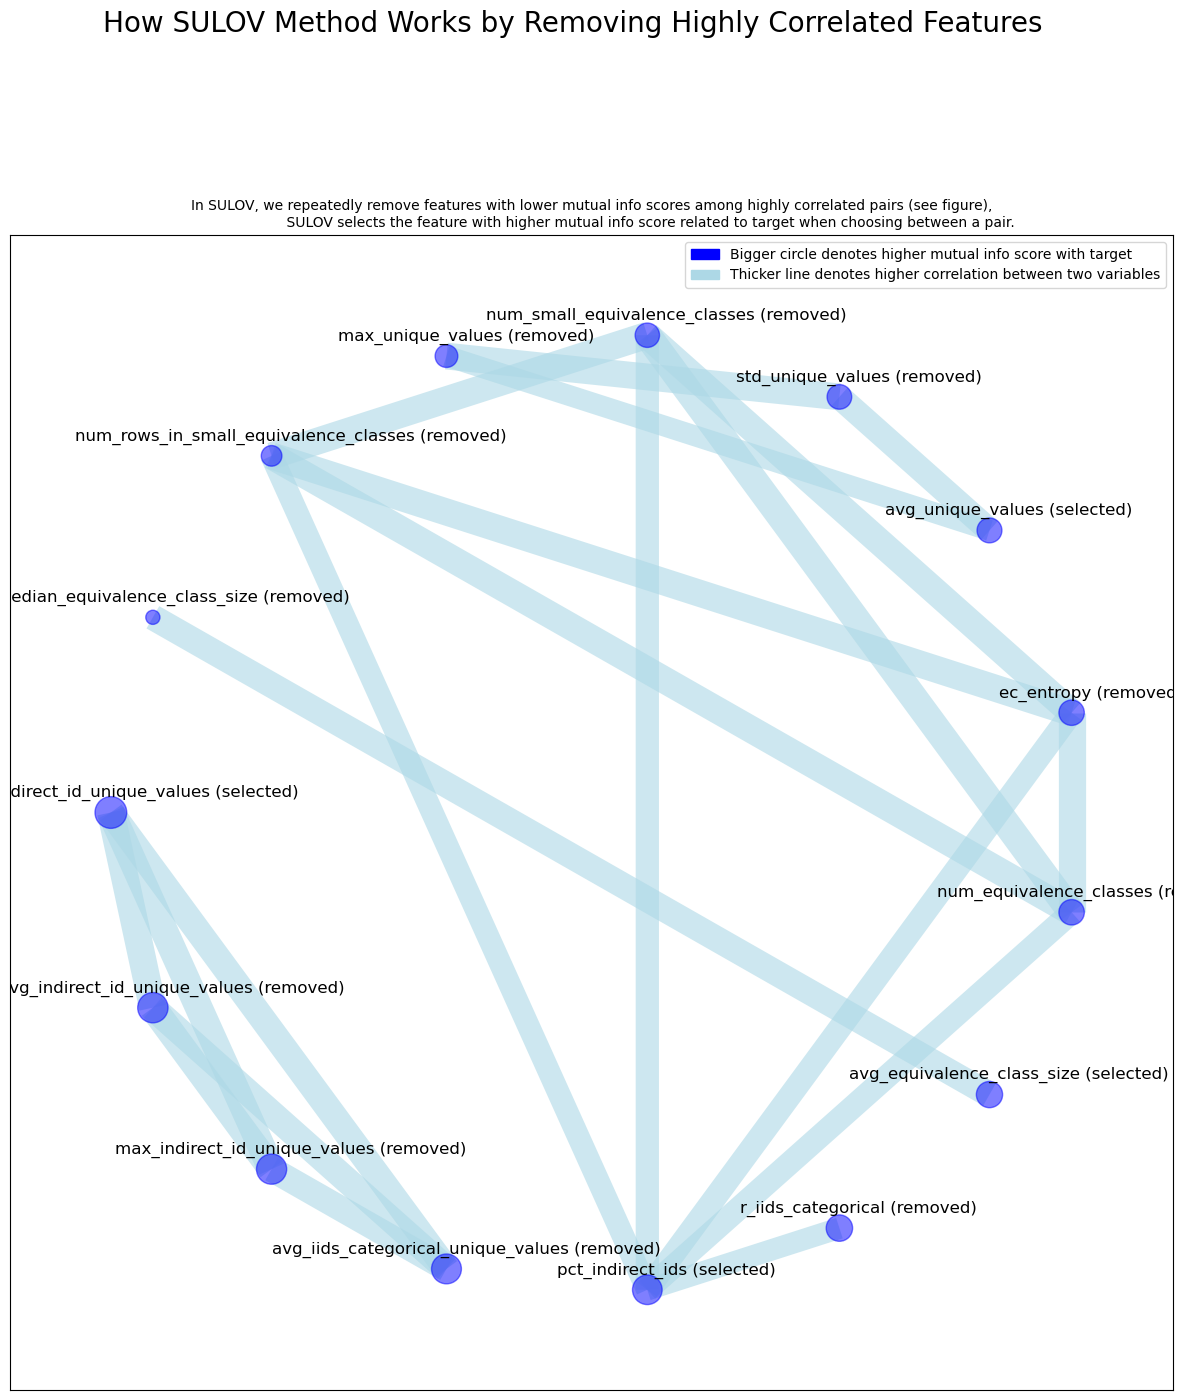

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 12
Final list of selected 12 vars after SULOV = ['pct_datetime', 'pct_string', 'cap_row_count', 'epochs', 'std_equivalence_class_size', 'type_SubsaltCTGAN', 'type_SubsaltCopulaGAN', 'type_SubsaltTVAE', 'std_indirect_id_unique_values', 'pct_indirect_ids', 'avg_equivalence_class_size', 'avg_unique_values']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 3 features per iteration...
    Number of booster rounds = 100
        Selected: ['pct_indirect_ids', 'cap_row_count', 'avg_unique_values']
            Time taken for regular XGBoost feature selection = 0 seconds
    

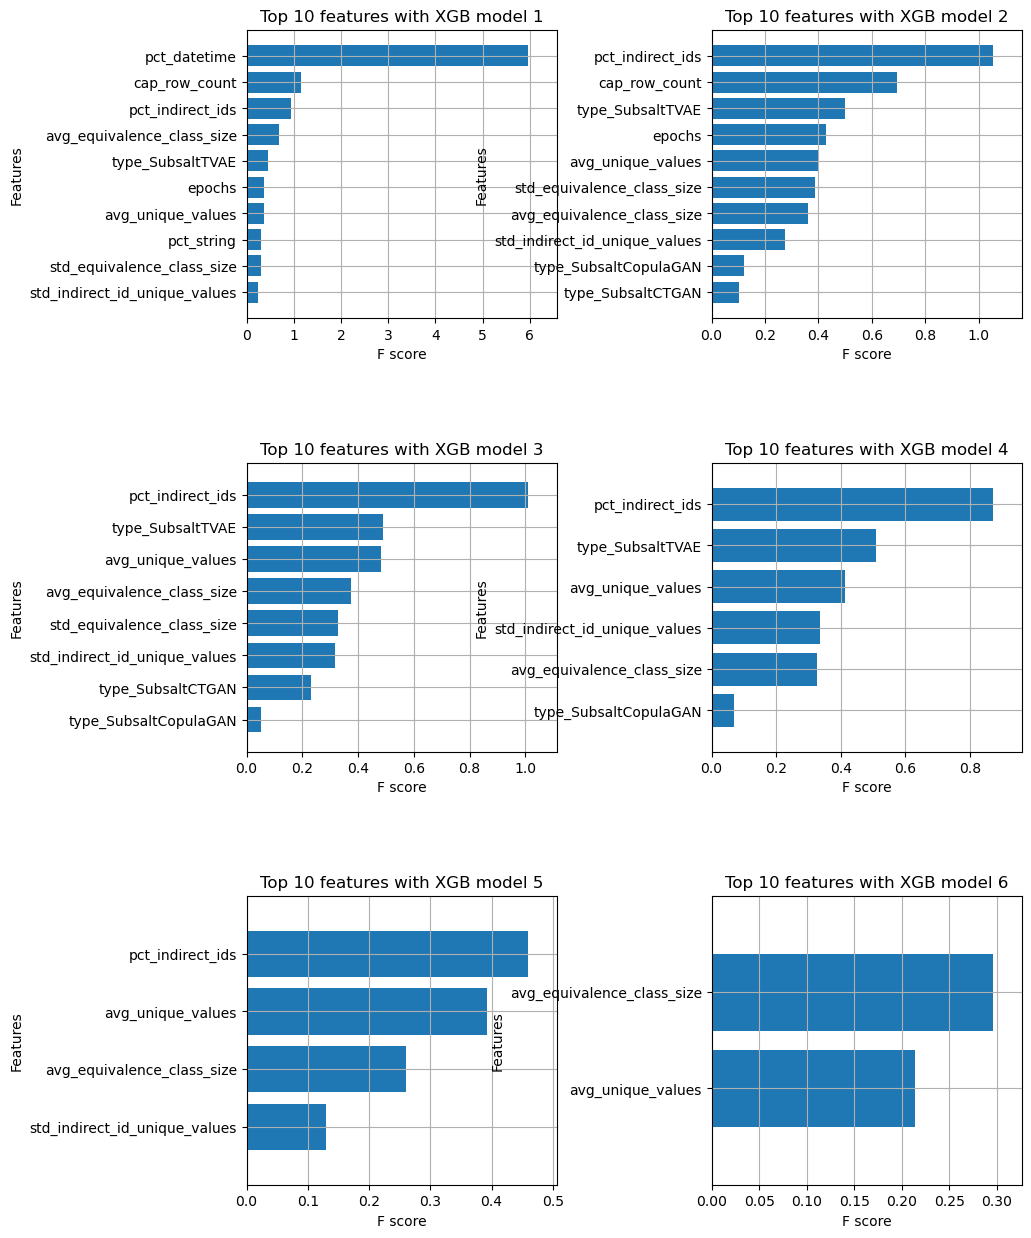

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['pct_indirect_ids', 'cap_row_count', 'avg_unique_values', 'std_equivalence_class_size', 'std_indirect_id_unique_values', 'avg_equivalence_class_size']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 6 important features and a train dataframe
Selected features: ['pct_indirect_ids', 'cap_row_count', 'avg_unique_values', 'std_equivalence_class_size', 'std_indirect_id_unique_values', 'avg_equivalence_class_size']
Top features: ['pct_indirect_ids', 'cap_row_count', 'avg_unique_values', 'std_equivalence_class_size']
		 WORKING ON TARGET: PRIVACY_Row memorization and PRIVACY_Row memorization_PASS
######################

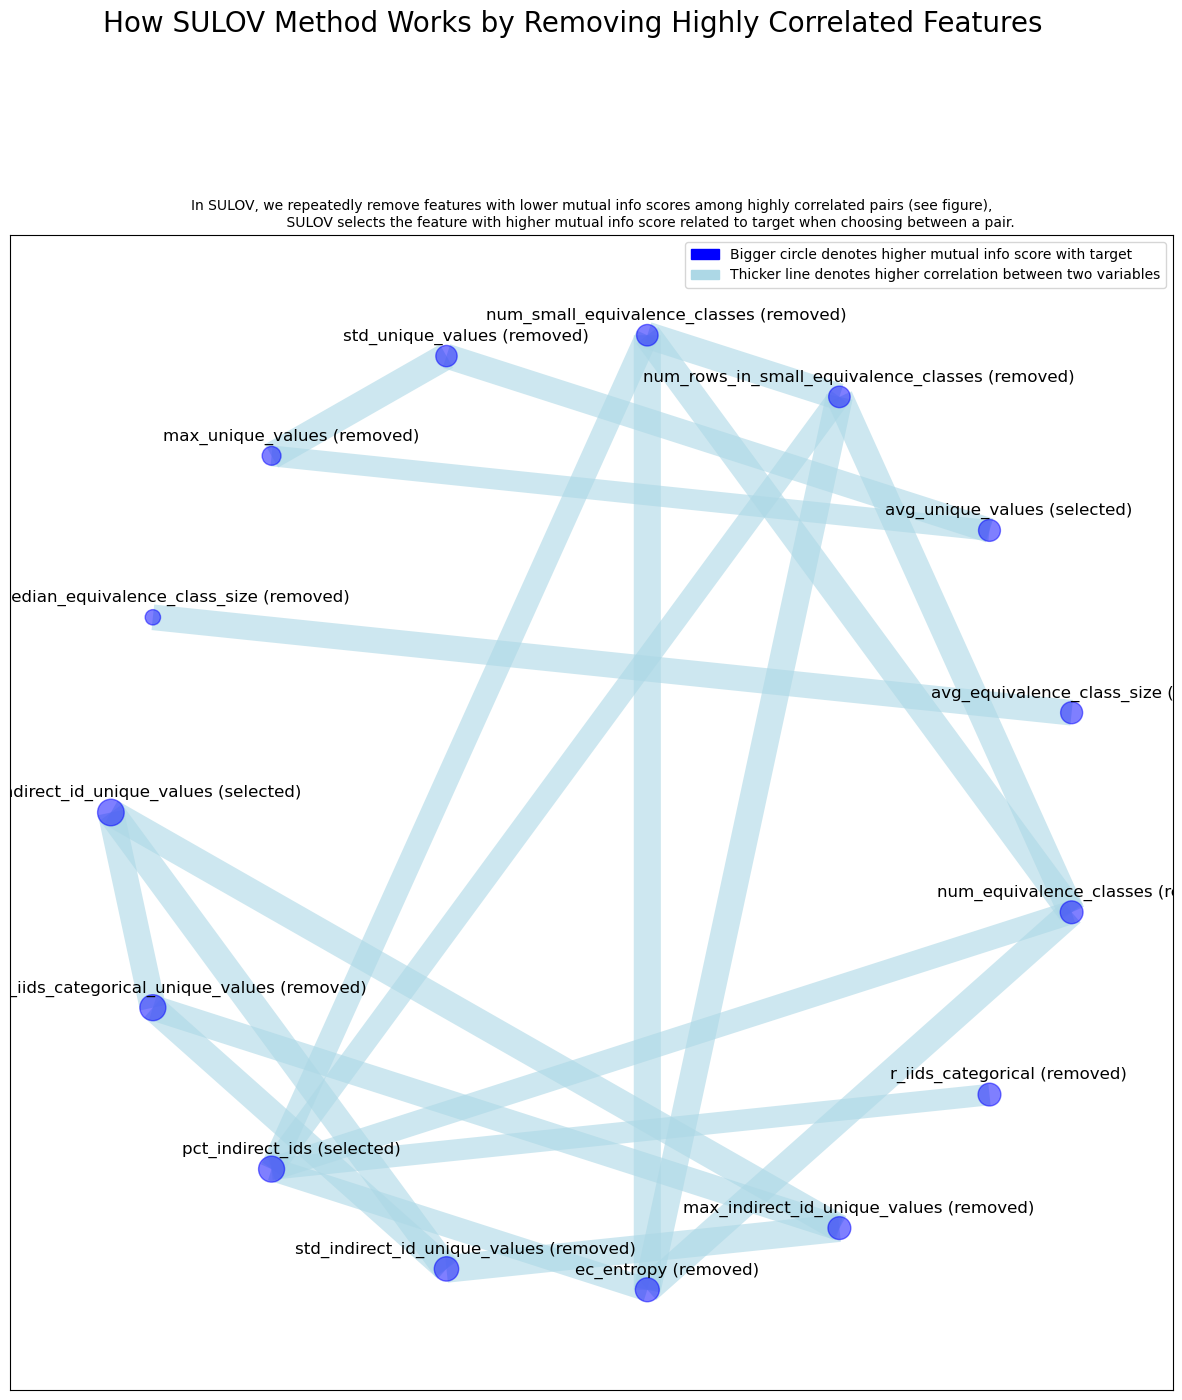

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 12
Final list of selected 12 vars after SULOV = ['pct_datetime', 'pct_string', 'cap_row_count', 'epochs', 'std_equivalence_class_size', 'type_SubsaltCTGAN', 'type_SubsaltCopulaGAN', 'type_SubsaltTVAE', 'avg_indirect_id_unique_values', 'pct_indirect_ids', 'avg_equivalence_class_size', 'avg_unique_values']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 3 features per iteration...
    Number of booster rounds = 100
        Selected: ['pct_indirect_ids', 'std_equivalence_class_size', 'cap_row_count']
            Time taken for regular XGBoost feature selection = 0 sec

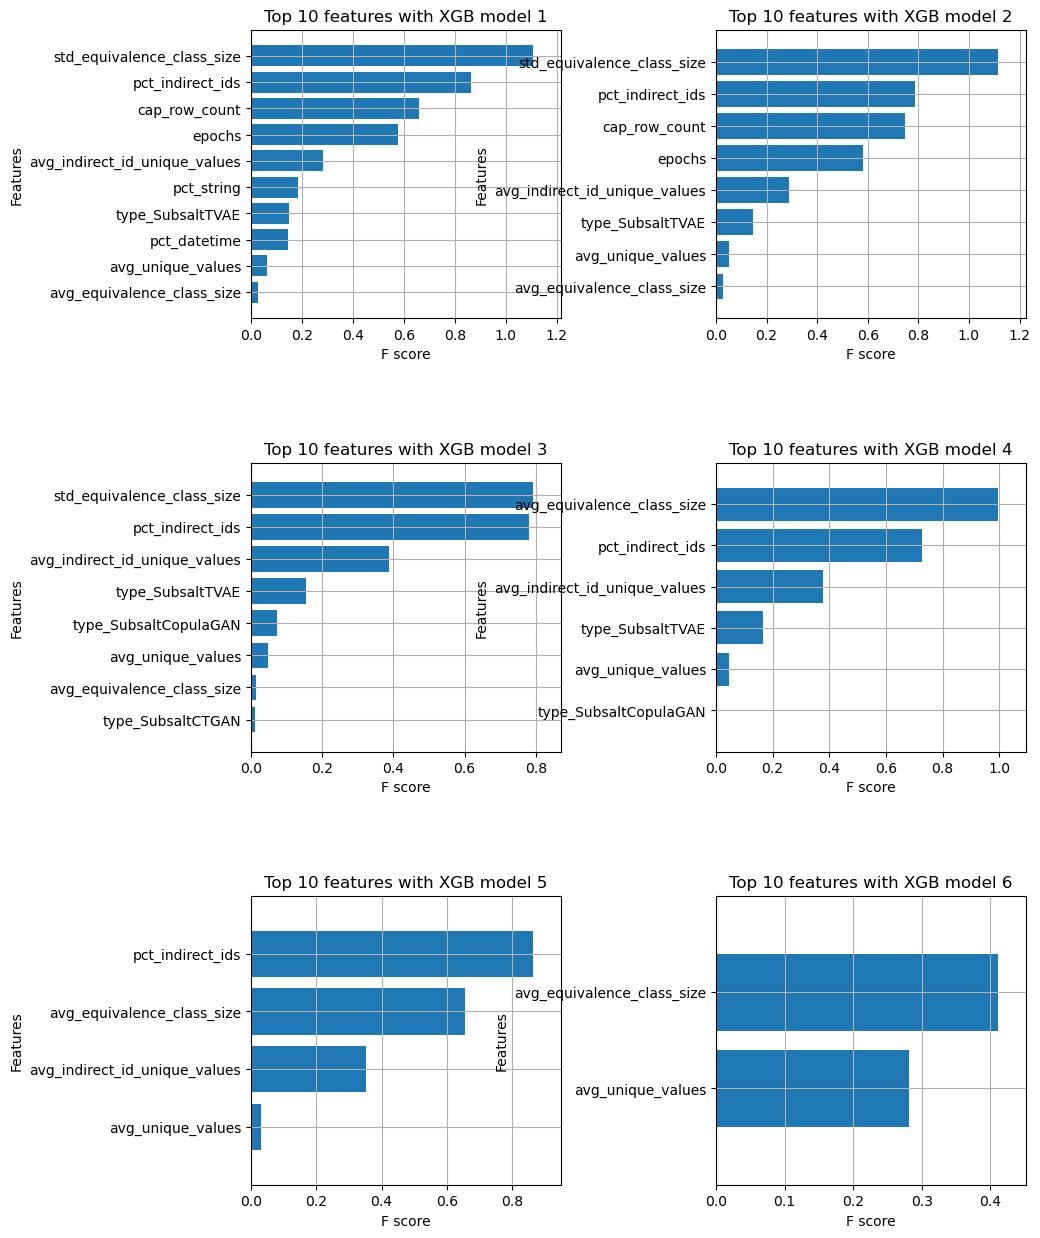

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['pct_indirect_ids', 'std_equivalence_class_size', 'cap_row_count', 'avg_indirect_id_unique_values', 'avg_equivalence_class_size', 'avg_unique_values']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 6 important features and a train dataframe
Selected features: ['pct_indirect_ids', 'std_equivalence_class_size', 'cap_row_count', 'avg_indirect_id_unique_values', 'avg_equivalence_class_size', 'avg_unique_values']
Top features: ['pct_indirect_ids', 'std_equivalence_class_size', 'cap_row_count', 'avg_indirect_id_unique_values']


In [ ]:
from sklearn.preprocessing import StandardScaler

for target in privacy_cols_numeric:
    binary_target = target + "_PASS"
    print(
        "====================================================================================================="
    )
    print(f"\t\t WORKING ON TARGET: {target} and {binary_target}")

    # Prepare data for both continuous and binary targets

    X_bin, y_bin = prepare_data(
        df_train,
        num_interactions=1,
        ignore_0=False,
        custom_interactions=[],
        ignore_cols=IGNORE,
        target=binary_target,
    )
    # Scale the data
    scaler = StandardScaler()
    X_bin_scaled = scaler.fit_transform(X_bin)

    # Convert scaled data back to a DataFrame
    X_bin_scaled = pd.DataFrame(X_bin_scaled, columns=X_bin.columns, index=X_bin.index)

    # Combine scaled features with the target
    combined_data = X_bin_scaled.join(y_bin)

    # Run featurewiz
    selected_features, trainm = fw.featurewiz(
        combined_data,
        target=binary_target,
        corr_limit=0.7,
        verbose=2,
        scoring="accuracy_score",
    )
    print("Selected features:", selected_features)
    # save the selected features list to a csv file
    with open(f"{target}_selected_features_fw_all.txt", "w") as f:
        f.write("\n".join(selected_features))
    # select the top k features:
    top_features = selected_features[:4]
    print("Top features:", top_features)
    with open(f"{target}_selected_features_fw.txt", "w") as f:
        f.write("\n".join(top_features))